# DVL Navigation and State Estimation

1. [Import Libraries](#import-libraries)
    1. [Glider Flight Computer Data](#import-glider-flight-computer)
    1. [Bathymetry Data](#import-bathymetry)
    1. [DVL Data](#import-dvl-data)
    1. [Select Time Series](#import-select-time-series)
1. [Load and Parse Data](#load-and-parse-data)
1. [Compute Water Column Currents](#compute-water-column-currents)
1. [Compute DVL-Odometry](#compute-dvl-odometry)
1. [Multi-Factor Terrain Based Navigation](#multi-factor-terrain-based-navigation)
1. [Sandbox](#sandbox)
1. [Unit Testing](#unit-testing)


---
<a id='import-libraries'></a>
## Import Libraries

In [1]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import scipy.signal
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.append(os.path.join(sys.path[0], '../data'))

# objects for parsing raw DVL data 
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries

# objects for estimating ocean current velocities
import VelocityShearPropagation

# objects for controlling thruster to minimize transport cost 
import AdaptiveVelocityController

# objects for parsing flight and science computer log files
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
import BathymetryMap

# data for parsing seafloor bathymetry
import bathy_meta_data
sns.set()

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(VelocityShearPropagation)
    importlib.reload(AdaptiveVelocityController)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)
    importlib.reload(bathy_meta_data)
    importlib.reload(BathymetryMap)

---
<a id='load-and-parse-data'></a>
## Load and/or Parse Data
<a id='import-glider-flight-computer'></a>
### A. Glider Flight Computer Data

In [2]:
reload_modules()
directory = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/dbd-parsed/sentinel_2019-Nov/"
ts_flight_kolumbo_all = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)

>> Parsing folder of ASC Files
>> Finished Parsing!


---
<a id='import-bathymetry'></a>
### B. Seafloor Bathymetry Data

In [3]:
# reload_modules()
# meta_dict = bathy_meta_data.BathyData["Kolumbo_full"]
# # meta_dict = bathy_meta_data.BathyData["Kolumbo"]
# bathy     = BathymetryMap.BathymetryMap(meta_dict=meta_dict)
# bathy.parse_bathy_file()

In [4]:
bathy_df = pd.read_csv('/Users/zduguid/Desktop/dat/Kolumbo-10m-sub.csv')

---
<a id='import-dvl-data'></a>
### C. DVL data 

In [5]:
reload_modules()
glider = "sentinel"
filepath = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-raw/%s/" % (glider)

#################################################
# File ID Number ################################
#################################################
filename2  = "sk211652.pd0" # DIVE 2
filename3  = "01820002.pd0" # DIVE 3
filename4  = "sk220034.pd0" # DIVE 4
filename5  = "01820008.pd0" # DIVE 5
filename7  = "01820013.pd0" # DIVE 7
filename9  = "sk222256.pd0" # DIVE 9
filename12 = "sk230350.pd0" # DIVE 12
filename14 = "sk261222.pd0" # DIVE 14

#################################################
# Parse Selected File IDs #######################
#################################################
# ts2  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename2,  save=False)
ts3  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename3,  save=False)
ts4  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename4,  save=False)
ts5  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename5,  save=False)
# ts7  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename7,  save=False)
# ts9  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename9,  save=False)
# ts12 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename12, save=False)
ts14 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename14, save=False)

#################################################
# Frontiers Naming Convention ###################
#################################################
# tsa  = ts14
# tsb  = ts12
# tsc  = ts2
# tsd  = ts3
# tse  = ts4
# tsf  = ts5

#################################################
# JFR Naming Convention #########################
#################################################
tsa  = ts5
tsb  = ts4
tsc  = ts3
tsd  = ts14

________________________________________
- Parsing DVL File ---------------------
    input file: 01820002.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
    # ensembles:   1000
    # ensembles:   1200
    # ensembles:   1400
    # ensembles:   1600
    # ensembles:   1800
    # ensembles:   2000
    # ensembles:   2200
    # ensembles:   2400
- Parsing Complete ---------------------
    # ensembles:   2410
    parsing time:  8.187127
- Sensor Configuration -----------------
    600kHz System
    Convex Beam Pattern
    Sensor Config #1
    Attached
    Down Facing
    30E Beam Angle
    4 Beam Janus
- Coordinate Transformation ------------
    Bin Mapping Used
    3-Beam Soln Used
    Tilts Used
    Earth Coords
________________________________________
- Parsing DVL File ---------------------
    input file: sk220034.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
- Parsing Complet

---
<a id='import-select-time-series'></a>
### D. Select Time Series 

In [6]:
ts = tsa

---
<a id='compute-water-column-currents'></a>
## Compute Water Column Currents 

In [7]:
reload_modules()

# tuning parameters for working with DVL data 
pitch_bias           =  8    # [deg]   mounting pitch bias for the sonar
start_filter         =  2    # [bin #] avoid using the first number of bins
end_filter           =  2    # [bin #] avoid using the last number of bins 
voc_mag_filter       =  1.0  # [m/s]   filter out ocean current 
voc_delta_mag_filter =  0.5  # [m/s]   filter out deltas between layers
near_surface_filter  = 10    # [m]     ignore Vtw when near surface 

# constants
DEG_TO_RAD = np.pi/180

# determine DVL parameters 
bin_len      = ts.df.depth_bin_length[0]
bin0_dist    = ts.df.bin0_distance[0]
bin_len      = np.cos(pitch_bias*DEG_TO_RAD)*bin_len
bin0_dist    = np.cos(pitch_bias*DEG_TO_RAD)*bin0_dist
max_range    = 80
max_depth    = int(np.max(ts.df.depth)+80)
x_beam       = 0
y_beam       = 1

# intialize water column
water_column = VelocityShearPropagation.WaterColumn(
    bin_len=bin_len, 
    bin0_dist=bin0_dist,
    max_depth=max_depth,
    start_filter=start_filter,
    end_filter=end_filter,
    voc_mag_filter=voc_mag_filter,
    voc_delta_mag_filter=voc_delta_mag_filter,
)

# iterate over the DVL ensembles 
for t in range(len(ts.df)):

    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    pitch = ts.df.pitch[t]
    roll  = ts.df.roll[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # extract Voc reference from bottom track velocity when available
    if not np.isnan(ts.df.abs_vel_btm_u[t]):
        vog_u = ts.df.abs_vel_btm_u[t]
        vog_v = ts.df.abs_vel_btm_v[t]
        voc_u = vog_u - vtw_u
        voc_v = vog_v - vtw_v
        voc_ref = VelocityShearPropagation.OceanCurrent(voc_u, voc_v, 0)
    else:
        voc_ref = VelocityShearPropagation.OceanCurrent()
        
    # add shear nodes for each DVL depth bin that meet the filter criteria
    num_good_vel_bins = ts.df.num_good_vel_bins[t]
    if num_good_vel_bins > start_filter+end_filter:        
        
        # determine if glider ascending or descending
        delta_z = ts.df.delta_z[t]
        if delta_z > 0:
            direction = 'descending'
        else:
            direction = 'ascending'

        # build list of velocity shears to add as ShearNode to water column
        delta_voc_u = []
        delta_voc_v = []

        # add all valid DVL bins to the shear list 
        #   + filtering of DVL bins will occur in the `add_shear_node` call
        for bin_num in range(int(num_good_vel_bins)):

            # retrieve the shear list from the DVL data 
            x_var = ts.get_profile_var_name('velocity', bin_num, x_beam)
            y_var = ts.get_profile_var_name('velocity', bin_num, y_beam)
            dvl_x = ts.df[x_var][t]
            dvl_y = ts.df[y_var][t]

            # compute delta between dead-reckoned through-water velocity & DVL
            delta_voc_u.append(vtw_u - (-dvl_x))
            delta_voc_v.append(vtw_v - (-dvl_y))

        shear_list = [VelocityShearPropagation.OceanCurrent(
                        delta_voc_u[i], 
                        delta_voc_v[i], 
                        0) 
                      for i in range(len(delta_voc_u))]

        # add shear node to the water column with shear list information 
        if len(shear_list):
            water_column.add_shear_node(
                z_true=depth,
                t=t,
                shear_list=shear_list,
                voc_ref=voc_ref,
                direction=direction,
                pitch=pitch,
                roll=roll,
            )

    # add voc_ref measurement to the water column even if shear list is empty  
    elif not voc_ref.is_none():
        water_column.add_shear_node(
            z_true=depth,
            t=t,
            shear_list=[],
            voc_ref=voc_ref,
            direction=direction,
            pitch=pitch,
            roll=roll,
        )
        
voc_u_list,voc_v_list,voc_w_list,voc_z_list = water_column.compute_averages()
print("> Finished Estimating Water Column Currents!")
# print(water_column.averages_to_str())

> Finished Estimating Water Column Currents!


---
<a id='compute-dvl-odometry'></a>
## Compute DVL-Odometry

In [8]:
# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_z = [0]

# set flag for setting GPS updates
flag_gps_fix_at_surface = False 

# extract the relevant portion of the glider flight computer
start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
dur     = end_t - start_t 
df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x = df_dbd.m_x_lmc[t]
        dbd_origin_y = df_dbd.m_y_lmc[t]
        break

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    time    = ts.df.time[t]
    prev_x  = rel_pos_x[-1]
    prev_y  = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.depth[t]
    
    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        flag_gps_fix_at_surface = False
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # retrieve over ground velocity from DVL in bottom track 
    vog_u = ts.df.abs_vel_btm_u[t]
    vog_v = ts.df.abs_vel_btm_v[t]
    
    # retrieve ocean current estimate from water column 
    voc_u = voc_u_list[int(depth)]
    voc_v = voc_v_list[int(depth)]

    # initialize delta values to zero
    delta_x, delta_y = 0,0
    
    # CASE 1: use bottom track overground velocity if available
    if (not np.isnan(vog_u)):
        delta_x = vog_u*delta_t
        delta_y = vog_v*delta_t
        
    # CASE 2: use through water velocity and ocean current estimate if available
    elif (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
            delta_x = (vtw_u + voc_u)*delta_t
            delta_y = (vtw_v + voc_v)*delta_t

    # CASE 3: use through water velocity if available
    elif (not np.isnan(vtw_u)):
            delta_x = vtw_u*delta_t
            delta_y = vtw_v*delta_t

    # CASE 4: use ocean current estimate if available
    elif (not np.isnan(voc_u)):
            delta_x = voc_u*delta_t
            delta_y = voc_v*delta_t

    # set current position to DVL odometry result 
    cur_x = delta_x + prev_x
    cur_y = delta_y + prev_y
    
    # override current position if GPS fix is given 
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_x_lmc) != 0):
            if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                cur_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x
                cur_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y
                flag_gps_fix_at_surface = True
    
    # update the odometry list of positions
    rel_pos_x.append(cur_x)
    rel_pos_y.append(cur_y)
    rel_pos_z.append(depth)

# add new odomety to the data frame
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z

print("> Finished Calculating Odometry!")

> Finished Calculating Odometry!


---
<a id='multi-factor-terrain-based-navigation'></a>
## Multi-Factor Terrain Based Navigation (MF-TBN)

In [9]:
# TODO 


---
<a id='plotting'></a>
## Plotting
### A. DVL-Odometry vs. Dead-Reckoning

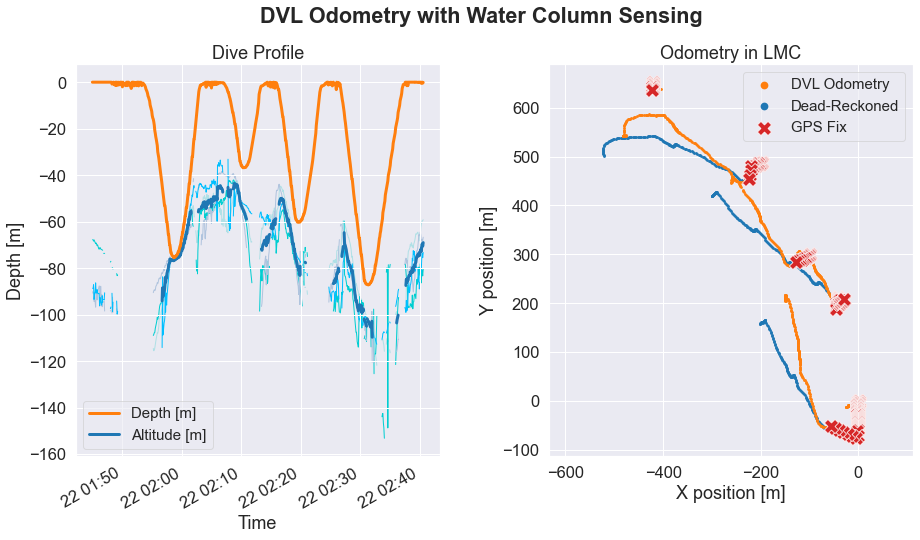

In [10]:
reload_modules()
dvl_plotter.plot_profile_and_odometry_and_dr(ts, ts_flight_kolumbo_all, save_name='tmp-profile.png')

---
### B. MF-TBN: Factor Extraction and Factor Seafloor Maps 
*Note: this plot is not displayed in the Jupyter notebook because it is too large to be displayed quickly. Instead, the plot is saved to the specified directory.*


In [11]:
reload_modules()
dvl_plotter.plot_profile_and_odometry_and_dr_and_three_factors(ts, ts_flight_kolumbo_all, bathy_df, save_name='tmp-three-factor.png')

---
### C. Water Column Currents

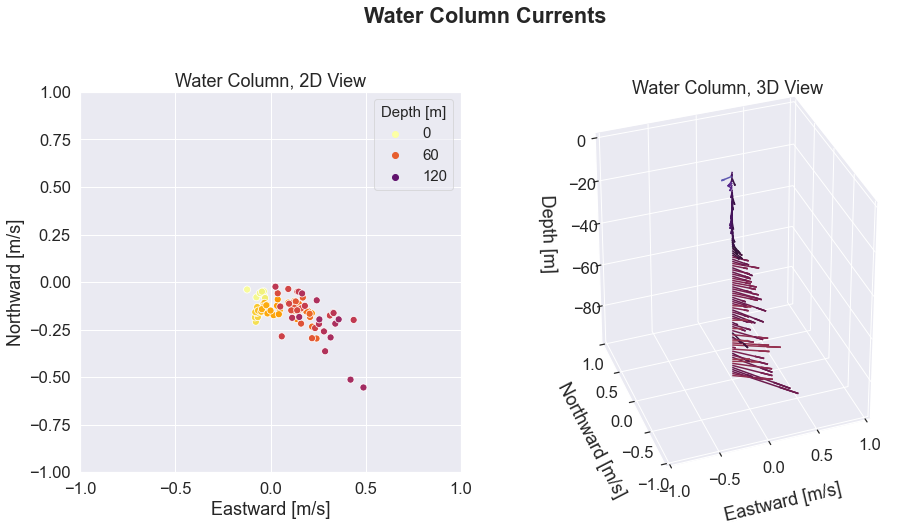

In [12]:
reload_modules()
dvl_plotter.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, voc_z_list, save_name='tmp-water-column.png')

--- 
<a id='sandbox'></a>
## Sandbox
Code below this cell is experimental and may contain bugs.

---
### Exploitative Depth Band Selection (EDBS)

### 5.1. Rescale Depth Band Selection (used for Strawman Mission)

In [ ]:
dive_b_depth   = 70
arctic_depth   = 80
strawman_voc_u = [voc_u_list[int((dive_b_depth/arctic_depth)*i)] for i in range(arctic_depth)]
strawman_voc_v = [voc_v_list[int((dive_b_depth/arctic_depth)*i)] for i in range(arctic_depth)]
strawman_voc_z = np.linspace(0,arctic_depth,arctic_depth)
strawman_voc_m = [np.linalg.norm([strawman_voc_u[i], strawman_voc_v[i]]) for i in range(len(strawman_voc_u))]

# fill NaN values 
for i in range(len(strawman_voc_u)):
    if np.isnan(strawman_voc_u[i]):
        strawman_voc_u[i] = strawman_voc_u[i-1]
        strawman_voc_v[i] = strawman_voc_v[i-1]
        
scaling_factor = 1
strawman_voc_u = list(np.array(strawman_voc_u)*scaling_factor)
strawman_voc_v = list(np.array(strawman_voc_v)*scaling_factor)


fig = plt.subplots(figsize=(15,8))
sns.scatterplot(strawman_voc_u, -strawman_voc_z, label='Eastward Velocity [m/s]')
sns.scatterplot(strawman_voc_v, -strawman_voc_z, label='Northward Velocity [m/s]')
sns.scatterplot(strawman_voc_m, -strawman_voc_z, label='Magnitude Velocity [m/s]')
plt.xlabel('Ocean Current [m/s]')
plt.ylabel('Depth [m]')


In [ ]:
print(get_depth_band_TC(70, 71, hotel=100, glider_heading=0, voc_u_list=strawman_voc_u, voc_v_list=strawman_voc_v, E_pump=2.95*3600*0.2, phi=5))
print(get_depth_band_TC(60, 79, hotel=100, glider_heading=0, voc_u_list=strawman_voc_u, voc_v_list=strawman_voc_v, E_pump=2.95*3600*0.2, phi=5))
print(get_depth_band_TC(0,  79, hotel=100, glider_heading=0, voc_u_list=strawman_voc_u, voc_v_list=strawman_voc_v, E_pump=2.95*3600*0.2, phi=5))

In [ ]:
for i in range(len(waypoints)-1):
    print(i, get_heading(waypoints[i], waypoints[i+1]))
    
"""
# HEADING LIST 
0 -0.06334   transit: (39,79) 
1 -0.16272   transit: (43,79)
2  2.97886   transit: (0,50)  
3  3.07825   transit: (0,61)

SURVEY LIST 
  0deg survey:  (39, 79)
 90deg survey:  ( 0, 52)
180deg survey:  ( 0, 48)
270deg survey:  (37, 79)

"""


heading_list = [_*np.pi/2 for _ in range(4)]
heading_list

In [ ]:
# constants 
E      = 100
phi    = 12
P_hotel_survey = 6.37
p_hotel_transit_reduced = 0.37 + 0.2 + 0.2
p_hotel_survey_reduced  = 0.37 + 1.75
v_list = np.linspace(0,1.5,50)

# select variables 
hotel          = p_hotel_transit_reduced
E_pump         = 2.95*3600  # [J]
E_reduced      = E_pump*0.2
phi_reduced    = 5
heading_list   = np.linspace(1,360,360)*np.pi/180
gyre_mag       = 0.0 
gyre_dir       = 315

# iterate over glider headings 
heading_list = [-0.06334, 
                -0.16272,
                 2.97886,
                 3.07825]

# survey heading list
heading_list = [_*np.pi/2 for _ in range(4)]

heading_list   = np.linspace(1,360,360)*np.pi/180

for glider_heading in heading_list:
    print("Exploitative Depth Band for Heading: %d" % (np.round(glider_heading*180/np.pi)))
    climb_list = []
    dive_list  = []
    TC_list    = []
    min_depth  = 0
    max_depth  = len(strawman_voc_u)
    gyre_u = gyre_mag*np.sin(gyre_dir*np.pi/180)
    gyre_v = gyre_mag*np.cos(gyre_dir*np.pi/180)
    depth_band_voc_u = list(np.array(strawman_voc_u) + gyre_u)
    depth_band_voc_v = list(np.array(strawman_voc_v) + gyre_v)
    
    # iterate through the valid combinations of dive-to and climb-to depths
    for z_dive in range(max_depth):
        if z_dive % 10 == 0:
            print("   dive depth: %d" % z_dive)
        for z_climb in range(z_dive):

            # update lists
            climb_list.append(z_climb)
            dive_list.append(z_dive)
            TC_list.append(get_depth_band_TC(z_climb, z_dive, hotel, glider_heading, depth_band_voc_u, depth_band_voc_v, E_pump=E_reduced, phi=phi_reduced))

    idx_min     = np.argmin(TC_list)
    opt_z_dive  = dive_list[idx_min]
    opt_z_climb = climb_list[idx_min]
    print("> found the optimal depth band!")
    print("    dive-to:  %d" % opt_z_dive)
    print("    climb-to: %d" % opt_z_climb)
    print("> generating plot")
    voc_u_list = np.array(depth_band_voc_u)
    voc_v_list = np.array(depth_band_voc_v)
    voc_w_list = np.array([0 for _ in depth_band_voc_u])
    voc_z_list = np.array(strawman_voc_z)
    plot_exploitative_depth_bands(dive_list, climb_list, TC_list, glider_heading, voc_u_list, voc_v_list, voc_w_list, voc_z_list)
    print()

In [ ]:
###############################################################################
# PLOT EXPLOITATIVE DEPTH BAND SELECTION
###############################################################################
# def plot_exploitative_depth_bands(dive_list, climb_list, TC_list, glider_heading, voc_u_list, voc_v_list, voc_w_list, voc_z_list, 
#     save_name=None):

In [ ]:
reload_modules()
voc_u_list = np.array(strawman_voc_u)
voc_v_list = np.array(strawman_voc_v)
voc_w_list = np.array([0 for _ in strawman_voc_u])
voc_z_list = np.array(strawman_voc_z)
dvl_plotter.plot_exploitative_depth_bands(dive_list, climb_list, TC_list, glider_heading, voc_u_list, voc_v_list, voc_w_list, voc_z_list)

In [ ]:
cum_u, cum_v = 0,0
count = 0

for i in range(len(strawman_voc_u)):
    if not np.isnan(strawman_voc_u[i]):
        cum_u += strawman_voc_u[i]
        cum_v += strawman_voc_v[i]
        count += 1

avg_voc_u, avg_voc_v = cum_u/count, cum_v/count
avg_voc_mag = np.linalg.norm([avg_voc_u, avg_voc_v])
avg_voc_ang = np.arctan2(avg_voc_u, avg_voc_v)
print(avg_voc_mag)
print(avg_voc_ang*180/np.pi)
print(avg_voc_ang*180/np.pi - -90)
print(avg_voc_ang*180/np.pi - -28.85)

In [ ]:
def get_distance(waypoint1, waypoint2):
    delta_x = waypoint2[0]-waypoint1[0]
    delta_y = waypoint2[1]-waypoint1[1]
    return(np.linalg.norm([delta_x, delta_y]))

def get_heading(waypoint1, waypoint2):
    delta_x = waypoint2[0]-waypoint1[0]
    delta_y = waypoint2[1]-waypoint1[1]
    return(np.arctan2(delta_x, delta_y))

energy_supply = 10*1000 # Whr

# mission from Kotzebue 
waypoints     = [(0,0), (-215000, 0), (-315000,185000), (-315000,1210000), (-315000,185000), (-215000,0), (0,0)]

# mission from Barrow (first mission)
waypoints     = [(579598-579598, 7912458-7912458), (412541-579598,  8124731-7912458), (518537-579598, 8661887-7912458), (412541-579598,  8124731-7912458), (579598-579598, 7912458-7912458)]

# mission from Barrow (second mission)
waypoints     = [(568824-568824, 7923411-7923411), (546996-568824, 8267564-7923411), (528927-568824, 8377622-7923411), (546996-568824, 8267564-7923411), (568824-568824, 7923411-7923411)]

dist_list = [get_distance(waypoints[i], waypoints[i+1]) for i in range(len(waypoints)-1)]
strawman_range = sum(dist_list) # [m]
strawman_range

In [ ]:
def p_buoyancy(pitch, depth_band):
    inflection_energy = 2.95 # Whrs
    DEG_TO_RAD = np.pi/180
    S_TO_HOUR  = 1/3600
    return (inflection_energy / ((2*depth_band / np.tan(pitch*DEG_TO_RAD))*S_TO_HOUR))

print(p_buoyancy(12, 50))
print(p_buoyancy(26, 50))

In [ ]:
hybrid_constant_speed_transit_vtw
hybrid_constant_speed_science_vtw

In [ ]:
p_default_dvl_msis_bsd   = 2.00 + 3.00 + 0.4 # W
p_reduce_dvl_msis_bsd    = 0.64 + 0.66 + 0.2 # W
p_other_hotel            = 0.97

p_hotel_transit_with_dvl = 0.37 + 2.0  + 0.4 # W
p_hotel_transit_reduced  = 0.37 + 0.64 + 0.2 # W
p_hotel_survey           = 0.37 + 6.0        # W
p_hotel_survey_reduced   = 0.37 + p_other_hotel + p_reduce_dvl_msis_bsd

In [ ]:
###########################################
# CONSTANTS 
# # these values are from the glider spreadsheet document 
# p_buoyancy_26deg_50m = 11.03   # Whr/km
# p_buoyancy_12deg_50m =  5.75   # Whr/km
# p_buoyancy_12deg_25m =  6.88   # Whr/km

buoyant_26deg_speed  = 0.37    # m/s
buoyant_12deg_speed  = 0.26    # m/s

p_default_dvl_msis_bsd   = 2.00 + 3.00 + 0.4 # W
p_reduce_dvl_msis_bsd    = 0.64 + 0.66 + 0.2 # W
p_other_hotel            = 0.97

p_hotel_transit_with_dvl = 0.37 + 2.0  + 0.4 # W
p_hotel_transit_reduced  = 0.37 + 0.64 + 0.2 # W
p_hotel_survey           = 0.37 + 6.0        # W
p_hotel_survey_reduced   = 0.37 + p_other_hotel + p_reduce_dvl_msis_bsd

# amount of buoyancy engine power (and speed) reduced
buoyancy_reduction       = 0.2  # value deduced after discussing with Rich 


res = 200
v_list = np.linspace(0,1.5,res)
hybrid_constant_speed_transit_vtw = get_opt_v(v_list, 0, 0, p_hotel_transit_with_dvl, energy_supply)
hybrid_constant_speed_science_vtw = get_opt_v(v_list, 0, 0, p_hotel_survey,           energy_supply)
hybrid_constant_speed_transit_pow = get_prop_power(hybrid_constant_speed_transit_vtw)
hybrid_constant_speed_science_pow = get_prop_power(hybrid_constant_speed_science_vtw)



###########################################
# CASE 1: 26 degree engine buoyancy engine 
buoyancy_26_deg_x = [0]
buoyancy_26_deg_y = [0]
buoyancy_26_deg_z = [0]
buoyancy_26_deg_t = [0]
buoyancy_26_deg_e = [0]
buoyancy_26_sci_d = 0
buoyancy_26_sci_t = 0
buoyancy_26_num_i = 0



###########################################
# CASE 2: 12 degree engine buoyancy engine 
buoyancy_12_deg_x = [0]
buoyancy_12_deg_y = [0]
buoyancy_12_deg_z = [0]
buoyancy_12_deg_t = [0]
buoyancy_12_deg_e = [0]
buoyancy_12_sci_d = 0
buoyancy_12_sci_t = 0
buoyancy_12_num_i = 0



###########################################
# CASE 3: constant hybrid speed 
hybrid_constant_x = [0]
hybrid_constant_y = [0]
hybrid_constant_z = [0]
hybrid_constant_t = [0]
hybrid_constant_e = [0]
hybrid_cons_sci_d = 0
hybrid_cons_sci_t = 0
hybrid_cons_num_i = 0



###########################################
# CASE 4: adaptive hybrid speed 
hybrid_adaptive_x = [0]
hybrid_adaptive_y = [0]
hybrid_adaptive_z = [0]
hybrid_adaptive_t = [0]
hybrid_adaptive_e = [0]
hybrid_adap_sci_d = 0
hybrid_adap_sci_t = 0
hybrid_adap_num_i = 0

hybrid_adap_vtw_d = {}
hybrid_adap_sci_vtw_d = {}
for waypoint_index in range(len(waypoints)-1):
    hybrid_adap_vtw_d[waypoint_index] = {}
    glider_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
    for z in range(arctic_depth):
        voc_u = strawman_voc_u[z]
        voc_v = strawman_voc_v[z]
        if np.isnan(voc_u):
            voc_u = 0
            voc_v = 0
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw            = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_transit_with_dvl, energy_supply)
        hybrid_adap_vtw_d[waypoint_index][z] = vtw
for i in range(4):
    glider_heading = 0 + i*(np.pi/2)
    hybrid_adap_sci_vtw_d[glider_heading] = {}
    for z in range(arctic_depth):
        gyre_u = 0.1*np.sin(315*np.pi/180)
        gyre_v = 0.1*np.cos(315*np.pi/180)
        
        voc_u = strawman_voc_u[z] + gyre_u
        voc_v = strawman_voc_v[z] + gyre_v
            
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw_sci        = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_survey*1, energy_supply)
        hybrid_adap_sci_vtw_d[glider_heading][z] = vtw_sci
        
        

###########################################
# CASE 5: reduced hotel load 
hybrid_reduce_h_x = [0]
hybrid_reduce_h_y = [0]
hybrid_reduce_h_z = [0]
hybrid_reduce_h_t = [0]
hybrid_reduce_h_e = [0]
hybrid_reduce_sci_d = 0
hybrid_reduce_sci_t = 0
hybrid_reduce_num_i = 0

hybrid_reduce_vtw_d = {}
hybrid_reduce_sci_vtw_d = {}
for waypoint_index in range(len(waypoints)-1):
    hybrid_reduce_vtw_d[waypoint_index] = {}
    glider_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
    for z in range(arctic_depth):
        voc_u = strawman_voc_u[z]
        voc_v = strawman_voc_v[z]
        if np.isnan(voc_u):
            voc_u = 0
            voc_v = 0
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw            = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_transit_reduced, energy_supply)
        hybrid_reduce_vtw_d[waypoint_index][z] = vtw
for i in range(4):
    glider_heading = 0 + i*(np.pi/2)
    hybrid_reduce_sci_vtw_d[glider_heading] = {}
    for z in range(arctic_depth):
        gyre_u = 0.1*np.sin(315*np.pi/180)
        gyre_v = 0.1*np.cos(315*np.pi/180)
        
        voc_u = strawman_voc_u[z] + gyre_u
        voc_v = strawman_voc_v[z] + gyre_v
        
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw_sci        = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_survey_reduced, energy_supply)
        hybrid_reduce_sci_vtw_d[glider_heading][z] = vtw_sci


###########################################
# CASE 6: exploitative depth banding 
# 25m depth banding -- should be twice as expensive compared to others 
hybrid_depthbnd_x = [0]
hybrid_depthbnd_y = [0]
hybrid_depthbnd_z = [0]
hybrid_depthbnd_t = [0]
hybrid_depthbnd_e = [0]

hybrid_depthbnd_sci_d = 0
hybrid_depthbnd_sci_t = 0
hybrid_depthbnd_num_i = 0


# compute_cases = {
#     1 : True,
#     2 : True, 
#     3 : True,  
#     4 : True, 
#     5 : True, 
#     6 : True, 
# }

compute_cases = {
    1 : False,
#     1 : True,
    2 : False,
#     2 : True,
    3 : False, 
#     3 : True, 
    4 : False, 
#     4 : True, 
#     5 : False,
    5 : True, 
#     6 : False,
    6 : True, 
}


# CASE 1 ##################################
if compute_cases[1]:
    print("> computing case 1")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (buoyancy_26_deg_x[-1], buoyancy_26_deg_y[-1])
        depth          =  buoyancy_26_deg_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(500000):
            prev_x, prev_y, prev_z = buoyancy_26_deg_x[-1], buoyancy_26_deg_y[-1], buoyancy_26_deg_z[-1]
            ocean_heading  = np.arctan2(avg_voc_u, avg_voc_v)
            delta_heading  = ocean_heading - glider_heading
            
            voc_hor        = buoyant_26deg_speed
            voc_ver        = np.tan(26*np.pi/180)*buoyant_26deg_speed*vertical_direction
            voc_para       = avg_voc_mag*np.cos(delta_heading)
            voc_perp       = avg_voc_mag*np.sin(delta_heading)
            vtw_para       = (voc_hor**2 - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*voc_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z 
            delta_e        = (delta_t/3600) * p_hotel_transit_with_dvl
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                buoyancy_26_num_i  +=  1
                buoyancy_26_deg_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
                
            # updates lists 
            buoyancy_26_deg_x.append(new_x)
            buoyancy_26_deg_y.append(new_y)
            buoyancy_26_deg_z.append(new_z)
            buoyancy_26_deg_t.append(delta_t)
            buoyancy_26_deg_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
        

# CASE 2 ##################################
if compute_cases[2]:
    print("> computing case 2")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 12
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (buoyancy_12_deg_x[-1], buoyancy_12_deg_y[-1])
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(500000):
            prev_x, prev_y, prev_z = buoyancy_12_deg_x[-1], buoyancy_12_deg_y[-1], buoyancy_12_deg_z[-1]
            ocean_heading  = np.arctan2(avg_voc_u, avg_voc_v)
            delta_heading  = ocean_heading - glider_heading
            
            voc_hor        = buoyant_12deg_speed
            voc_ver        = np.tan(12*np.pi/180)*buoyant_12deg_speed*vertical_direction
            voc_para       = avg_voc_mag*np.cos(delta_heading)
            voc_perp       = avg_voc_mag*np.sin(delta_heading)
            vtw_para       = (voc_hor**2 - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*voc_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            delta_e        = (delta_t/3600) * p_hotel_transit_with_dvl 
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                buoyancy_12_num_i  +=  1
                buoyancy_12_deg_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
                
            # updates lists 
            buoyancy_12_deg_x.append(new_x)
            buoyancy_12_deg_y.append(new_y)
            buoyancy_12_deg_z.append(new_z)
            buoyancy_12_deg_t.append(delta_t)
            buoyancy_12_deg_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(buoyancy_12_deg_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)

            ocean_heading  = np.arctan2(avg_voc_u+gyre_u, avg_voc_v+gyre_v)
            ocean_mag      = np.linalg.norm([avg_voc_u+gyre_u, avg_voc_v+gyre_v])
            delta_heading  = ocean_heading - glider_heading 

            vtw_hor        = buoyant_12deg_speed
            vtw_ver        = buoyant_12deg_speed*np.tan(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            buoyancy_12_sci_d +=  delta_dist
            buoyancy_12_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                buoyancy_12_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
            
        
        
# CASE 3 ##################################
if compute_cases[3]:
    print("> computing case 3")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 12
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_constant_x[-1], hybrid_constant_y[-1])
        curr_depth     =  hybrid_constant_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_constant_x[-1], hybrid_constant_y[-1], hybrid_constant_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_constant_speed_transit_vtw    
            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction            
            
            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            p_total        = p_hotel_transit_with_dvl + hybrid_constant_speed_transit_pow
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                hybrid_cons_num_i  +=  1
                hybrid_constant_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_constant_x.append(new_x)
            hybrid_constant_y.append(new_y)
            hybrid_constant_z.append(new_z)
            hybrid_constant_t.append(delta_t)
            hybrid_constant_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(hybrid_constant_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_constant_speed_science_vtw    
            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_cons_sci_d +=  delta_dist
            hybrid_cons_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_cons_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            
# CASE 4 ##################################
if compute_cases[4]:
    print("> computing case 4")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 12
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_adaptive_x[-1], hybrid_adaptive_y[-1])
        curr_depth     =  hybrid_adaptive_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_adaptive_x[-1], hybrid_adaptive_y[-1], hybrid_adaptive_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_adap_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            p_total        = p_hotel_transit_with_dvl + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                hybrid_adaptive_e.append(2.95)
                hybrid_adap_num_i  +=  1
                vertical_direction *= -1
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_adaptive_x.append(new_x)
            hybrid_adaptive_y.append(new_y)
            hybrid_adaptive_z.append(new_z)
            hybrid_adaptive_t.append(delta_t)
            hybrid_adaptive_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(hybrid_adaptive_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_adap_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_adap_sci_d +=  delta_dist
            hybrid_adap_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_adap_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            
# CASE 5 ##################################
if compute_cases[5]:
    print("> computing case 5")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 5
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_reduce_h_x[-1], hybrid_reduce_h_y[-1])
        curr_depth     =  hybrid_reduce_h_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_reduce_h_x[-1], hybrid_reduce_h_y[-1], hybrid_reduce_h_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_reduce_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            # TODO
            p_total        = p_hotel_transit_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                hybrid_reduce_h_e.append(2.95*buoyancy_reduction)
                hybrid_reduce_num_i +=  1
                vertical_direction  *= -1
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_reduce_h_x.append(new_x)
            hybrid_reduce_h_y.append(new_y)
            hybrid_reduce_h_z.append(new_z)
            hybrid_reduce_h_t.append(delta_t)
            hybrid_reduce_h_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
    
    # perform science
    science_energy = energy_supply - sum(hybrid_reduce_h_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_reduce_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_reduce_sci_d +=  delta_dist
            hybrid_reduce_sci_t +=  delta_t
            science_energy      += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_reduce_num_i +=  1
                science_energy      += -2.95*buoyancy_reduction
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
            
            
# CASE 6 ##################################
if compute_cases[6]:
    print("> computing case 6")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 5
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position    = (hybrid_depthbnd_x[-1], hybrid_depthbnd_y[-1])
        curr_depth       =  hybrid_depthbnd_z[-1]
        next_waypoint    = waypoints[waypoint_index+1]
        glider_heading   = get_heading(curr_position, next_waypoint)
        waypoint_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
        
        # result of optimal depth band algorithm 
        epsilon     = 0.0001
        z_climb     = 0
        z_dive      = len(strawman_voc_u)-1
        if   abs(waypoint_heading - (-0.06334)) < epsilon:
            z_climb = 39
            z_dive  = 79
        elif abs(waypoint_heading - (-0.16272)) < epsilon:
            z_climb = 43
            z_dive  = 79
        elif abs(waypoint_heading - ( 2.97886)) < epsilon:
            z_climb = 0
            z_dive  = 50
        elif abs(waypoint_heading - ( 3.07825)) < epsilon:
            z_climb = 0
            z_dive  = 61
        # 0 -0.06334   transit: (39,79)  survey: (43,79)
        # 1 -0.16272   transit: (43,79)  survey: (45,79)
        # 2  2.97886   transit: (0,50)   survey: (0, 45)
        # 3  3.07825   transit: (0,61)   survey: (0, 48)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_depthbnd_x[-1], hybrid_depthbnd_y[-1], hybrid_depthbnd_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_reduce_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            # TODO
            p_total        = p_hotel_transit_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            

            half_depth    = int(arctic_depth/2)
            overlap       = 10
            if new_z > z_dive:
                new_z = z_dive
                hybrid_depthbnd_e.append(2.95*buoyancy_reduction)
                hybrid_depthbnd_num_i +=  1
                vertical_direction    *= -1
            elif new_z < z_climb:
                new_z = z_climb
                vertical_direction *= -1

            # updates lists 
            hybrid_depthbnd_x.append(new_x)
            hybrid_depthbnd_y.append(new_y)
            hybrid_depthbnd_z.append(new_z)
            hybrid_depthbnd_t.append(delta_t)
            hybrid_depthbnd_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
    
    # perform science
    science_energy = energy_supply - sum(hybrid_depthbnd_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        z_dive  = len(strawman_voc_u) - 1
        z_climb = 0
        epsilon = 0.0001
        if   abs(glider_heading - 0.00000) < epsilon:
            z_climb = 39
            z_dive  = 79
        elif abs(glider_heading - 1.57079) < epsilon:
            z_climb = 0 
            z_dive  = 52
        elif abs(glider_heading - 3.14159) < epsilon:
            z_climb = 0
            z_dive  = 48
        elif abs(glider_heading - 4.71238) < epsilon:
            z_climb = 37
            z_dive  = 79
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_reduce_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_depthbnd_sci_d +=  delta_dist
            hybrid_depthbnd_sci_t +=  delta_t
            science_energy        += -delta_e

            if new_z > z_dive:
                new_z = z_dive
                vertical_direction    *= -1
                hybrid_depthbnd_num_i +=  1
                science_energy        += -2.95*buoyancy_reduction
            elif new_z < z_climb:
                new_z = z_climb
                vertical_direction *= -1
            


distance_traveled_26 = \
    sum([get_distance((buoyancy_26_deg_x[i],  buoyancy_26_deg_y[i]), 
                      (buoyancy_26_deg_x[i+1],buoyancy_26_deg_y[i+1]))
        for i in range(len(buoyancy_26_deg_x)-1)])

distance_traveled_12 = \
    sum([get_distance((buoyancy_12_deg_x[i],  buoyancy_12_deg_y[i]), 
                      (buoyancy_12_deg_x[i+1],buoyancy_12_deg_y[i+1]))
        for i in range(len(buoyancy_12_deg_x)-1)])

distance_traveled_constant_thrust = \
    sum([get_distance((hybrid_constant_x[i],  hybrid_constant_y[i]), 
                      (hybrid_constant_x[i+1],hybrid_constant_y[i+1]))
        for i in range(len(hybrid_constant_x)-1)])

distance_traveled_adaptive_thrust = \
    sum([get_distance((hybrid_adaptive_x[i],  hybrid_adaptive_y[i]), 
                      (hybrid_adaptive_x[i+1],hybrid_adaptive_y[i+1]))
        for i in range(len(hybrid_adaptive_x)-1)])

distance_traveled_reduced_hotel = \
    sum([get_distance((hybrid_reduce_h_x[i],  hybrid_reduce_h_y[i]), 
                      (hybrid_reduce_h_x[i+1],hybrid_reduce_h_y[i+1]))
        for i in range(len(hybrid_reduce_h_x)-1)])

distance_traveled_depth_band = \
    sum([get_distance((hybrid_depthbnd_x[i],  hybrid_depthbnd_y[i]), 
                      (hybrid_depthbnd_x[i+1],hybrid_depthbnd_y[i+1]))
        for i in range(len(hybrid_depthbnd_x)-1)])

print()
if compute_cases[1]:
    print('- 1. Buoyancy Driven at 26 deg ------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_26/1000))
    print('      transit time: %f [day]'  % (sum(buoyancy_26_deg_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(buoyancy_26_deg_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(buoyancy_26_deg_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (buoyancy_26_sci_d/1000))
    print('      science time: %f [day]'  % (buoyancy_26_sci_t/60/60/24))
    print('      # inflection: %d'        % (buoyancy_26_num_i))
    print('       improvement: %f'        % (0))
    print()

if compute_cases[2]:
    print('- 2. Buoyancy Driven at 12 deg ------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_12/1000))
    print('      transit time: %f [day]'  % (sum(buoyancy_12_deg_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(buoyancy_12_deg_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(buoyancy_12_deg_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (buoyancy_12_sci_d/1000))
    print('      science time: %f [day]'  % (buoyancy_12_sci_t/60/60/24))
    print('      # inflection: %d'        % (buoyancy_12_num_i))
    print('       improvement: %f'        % ((buoyancy_12_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[3]:
    print('- 3. Hybrid Constant Speed ----------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_constant_thrust/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_constant_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_constant_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_constant_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_cons_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_cons_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_cons_num_i))
    print('       improvement: %f'        % ((hybrid_cons_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[4]:
    print('- 4. Hybrid Adaptive Speed ----------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_adaptive_thrust/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_adaptive_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_adaptive_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_adaptive_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_adap_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_adap_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_adap_num_i))
    print('       improvement: %f'        % ((hybrid_adap_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[5]:
    print('- 5. Reduced Hotel Load -------------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_reduced_hotel/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_reduce_h_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_reduce_h_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_reduce_h_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_reduce_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_reduce_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_reduce_num_i))
    print('       improvement: %f'        % ((hybrid_reduce_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    

if compute_cases[6]:
    print('- 6. Exploitative Depth Banding -----------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_depth_band/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_depthbnd_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_depthbnd_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_depthbnd_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_depthbnd_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_depthbnd_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_depthbnd_num_i))
    print('       improvement: %f'        % ((hybrid_depthbnd_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()

In [ ]:
baseline_range

In [ ]:
"""

IMPROVEMENT IN CASE 6 FOR USING DEPTH BANDING IN SURVEY MODE OR NOT 
NO SURVEY -- IMPROVEMENT = 371 (4% increase from case 5 just from better transit)
W/ SURVEY -- IMPROVEMENT = 





TRANSIT USED TRULY OPTIMAL DEPTH BAND APPROACH

- 6. Exploitative Depth Banding -----------------------
      transit dist: 912.736614 [km]
      transit time: 16.663889 [day]
      transit ener: 1.493757 [kWhr]
      transit econ: 5.891551 [J/m]
      science dist: 3140.300000 [km]
      science time: 53.024706 [day]
      # inflection: 2406
       improvement: 352.741089
       
TRANSIT AND SURVEY USING EXPLOITATIVE DEPTH BAND 

- 6. Exploitative Depth Banding -----------------------
      transit dist: 912.736614 [km]
      transit time: 16.663889 [day]
      transit ener: 1.493757 [kWhr]
      transit econ: 5.891551 [J/m]
      science dist: 3688.500000 [km]
      science time: 58.838795 [day]
      # inflection: 2506
       improvement: 413.977085
       
       
       
       
RESULTS FROM USING 10m LEGS    

- 3. Hybrid Constant Speed ----------------------------
      transit dist: 912.738499 [km]
      transit time: 11.035069 [day]
      transit ener: 5.242356 [kWhr]
      transit econ: 20.676466 [J/m]
      science dist: 668.970000 [km]
      science time: 7.126571 [day]
      # inflection: 2151
       improvement: 76.684261

- 4. Hybrid Adaptive Speed ----------------------------
      transit dist: 912.724239 [km]
      transit time: 10.562384 [day]
      transit ener: 5.196713 [kWhr]
      transit econ: 20.496443 [J/m]
      science dist: 685.610000 [km]
      science time: 6.794210 [day]
      # inflection: 2126
       improvement: 78.543012
       
       
# Percent of survey mode
# interestingly, 42 percent of survey mode performs the best. 
# this might be due to the fact that buoyancy power and speed
# are unaccounted for in the optimization routine
0.00 -- 76.29
0.25 -- 84.45
0.35 -- 84.83
0.39 -- 84.94
0.40 -- 84.96
0.41 -- 85.01
0.42 -- 85.01
0.43 -- 85.01
0.44 -- 84.47
0.45 -- 84.49
0.50 -- 84.56
0.60 -- 84.56
0.70 -- 81.48
"""


---
## Adaptive Velocity Control

Compare the performance of three glider control policies:
1. Constant velocity with buoyancy engine alone
2. Constant velocity with hybrid thruster (speed optimized w.r.t. hotel)
3. Adaptive velocity with hybrid thruster (speed optimized w.r.t. hotel and ocean currents)

In [ ]:
# TODO list 
#   + take water column average for buoyancy case
    
# constants 
survey_hotel  = 6.37
E             = 3000
depth_filter  = 5
# eta           = 5.16
eta           = 2.68
# eta           = 8.95
# eta           = 1.57
constant_buoyancy_vtw    = 0.37
constant_buoyancy_p_prop = eta*(1/1000)*(3600/1)*(constant_buoyancy_vtw/1)

# possible velocities for adaptive controller to choose from
res    = 151
v_list = np.linspace(0,1.5,res)

# through water velocities for the two constant velocities conditions 
constant_hybrid_vtw    = get_opt_v(v_list, 0, 0, survey_hotel, E)
constant_hybrid_p_prop = get_prop_power(constant_hybrid_vtw)
constant_buoyancy_vtw  = 0.37

# initialize list of metrics that we are keeping track of 
mission_distance           = [0]
mission_currents_forward   = [0]
mission_currents_starboard = [0]
mission_currents_mag       = [0]

constant_buoyancy_time     = [0]
constant_buoyancy_energy   = [0] 

constant_hybrid_time       = [0]
constant_hybrid_energy     = [0] 

adaptive_hybrid_time       = [0]
adaptive_hybrid_energy     = [0]
adaptive_hybrid_velocity   = [0]
adaptive_hybrid_prop_p     = [0] 

# get averages of water column
cum_u,cum_v = 0,0
count = 0
for i in range(len(voc_u_list)):
    if not(np.isnan(voc_u_list[i])):
        cum_u   += voc_u_list[i]
        cum_v   += voc_v_list[i]
        count   += 1
avg_column_voc_u  = cum_u/count
avg_column_voc_v  = cum_v/count
avg_ocean_heading = np.arctan2(avg_column_voc_u,      avg_column_voc_v)
avg_ocean_mag     = np.linalg.norm([avg_column_voc_u, avg_column_voc_v])


# iterate over the dive to extract the optimal values
for t in range(1,len(ts.df)):
    # compute path of the glider 
    # + NOTE: all control models follow the same path
    # + NOTE: dont include time at surface (not relevant to transit)
    depth    = ts.df.depth[t]
    delta_x, delta_y = 0, 0
    if depth > depth_filter:
        delta_x  = ts.df.delta_x[t]
        delta_y  = ts.df.delta_y[t]
    distance = np.linalg.norm([delta_x, delta_y])
    
    # compute ocean current conditions at this location
    voc_u          = voc_u_list[int(depth)]
    voc_v          = voc_v_list[int(depth)]
    if np.isnan(voc_u):
        voc_u = 0
        voc_v = 0
    glider_heading = np.arctan2(delta_x, delta_y)
    ocean_heading  = np.arctan2(voc_u,   voc_v)
    ocean_mag      = np.linalg.norm([voc_u, voc_v])
    delta_heading  = ocean_heading - glider_heading 
    voc_para       = ocean_mag*np.cos(delta_heading)
    voc_perp       = ocean_mag*np.sin(delta_heading)
    
    # compute velocity components for water column average for buoyancy engine
    avg_delta_heading = avg_ocean_heading - glider_heading
    avg_voc_para      = avg_ocean_mag*np.cos(delta_heading)
    avg_voc_perp      = avg_ocean_mag*np.sin(delta_heading)
    
    # update mission lists 
    mission_distance.append(distance)
    mission_currents_forward.append(voc_para)
    mission_currents_starboard.append(voc_perp)
    mission_currents_mag.append(ocean_mag)
    
    # buoyancy control case 
    constant_buoyancy_vtw_para = (constant_buoyancy_vtw**2   - avg_voc_perp**2)**0.5
    constant_buoyancy_vog_para = (constant_buoyancy_vtw_para + avg_voc_para)
    delta_t                    = distance / constant_buoyancy_vog_para 
    constant_buoyancy_time.append(delta_t)
    constant_buoyancy_energy.append(delta_t * (constant_buoyancy_p_prop + survey_hotel))
    
    # constant hybrid control case 
    constant_hybrid_vtw_para = (constant_hybrid_vtw**2   - voc_perp**2)**0.5
    constant_hybrid_vog_para = (constant_hybrid_vtw_para + voc_para)
    delta_t                  = distance / constant_hybrid_vog_para 
    constant_hybrid_time.append(delta_t)
    constant_hybrid_energy.append(delta_t * (constant_hybrid_p_prop + constant_buoyancy_p_prop + survey_hotel))
    
    # adaptive hybrid control case 
    adaptive_hybrid_vtw      = get_opt_v(v_list, ocean_mag, delta_heading, survey_hotel, E)
    adaptive_hybrid_vtw_para = (adaptive_hybrid_vtw**2   - voc_perp**2)**0.5
    adaptive_hybrid_vog_para = (adaptive_hybrid_vtw_para + voc_para)
    delta_t                  = distance / adaptive_hybrid_vog_para 
    adaptive_hybrid_p_prop   = get_prop_power(adaptive_hybrid_vtw)
    adaptive_hybrid_time.append(delta_t)
    adaptive_hybrid_energy.append(delta_t * (adaptive_hybrid_p_prop + constant_buoyancy_p_prop + survey_hotel))
    adaptive_hybrid_velocity.append(adaptive_hybrid_vtw)
    

print('Mission Distance:  %.3f km'   % float(sum(mission_distance)/1000))
print()
print('Constant Buoyancy')
print('  Energy Consumed: %.3f Whrs' % float(sum(constant_buoyancy_energy)/3600))
print('  Mission Time:    %.3f min'  % float(sum(constant_buoyancy_time)/60))
print()
print('Constant Hybrid')
print('  Energy Consumed: %.3f Whrs' % float(sum(constant_hybrid_energy)/3600))
print('  Mission Time:    %.3f min'  % float(sum(constant_hybrid_time)/60))
print()
print('Adaptive Hybrid')
print('  Energy Consumed: %.3f Whrs' % float(sum(adaptive_hybrid_energy)/3600))
print('  Mission Time:    %.3f mins' % float(sum(adaptive_hybrid_time)/60))

### Plot Adaptive Speed Control 

In [ ]:
fig, ax = plt.subplots(2, figsize=(15,8))
roll_size = 20


roll_adaptive_hybrid_velocity   = list(pd.Series(adaptive_hybrid_velocity).rolling(roll_size).mean())
roll_mission_currents_forward   = list(pd.Series(mission_currents_forward).rolling(roll_size).mean())
roll_mission_currents_starboard = list(pd.Series(mission_currents_starboard).rolling(roll_size).mean())
ts.df['roll_adaptive_hybrid_velocity']   = roll_adaptive_hybrid_velocity
ts.df['roll_mission_currents_forward']   = roll_mission_currents_forward
ts.df['roll_mission_currents_starboard'] = roll_mission_currents_starboard
ts.df['roll_constant_hybrid_velocity']   = list(np.ones(len(roll_adaptive_hybrid_velocity))*constant_hybrid_vtw)
ts.df.roll_adaptive_hybrid_velocity.plot.line(lw=3,   ax=ax[0], label='Hybrid Adaptive Speed', color='tab:orange', zorder=5)
ts.df.roll_constant_hybrid_velocity.plot.line(lw=3,   ax=ax[0], label='Hybrid Constant Speed', color='tab:blue')

ts.df.roll_mission_currents_forward.plot.line(lw=3,   ax=ax[1], label='Forward Currents',   color='tab:green')
ts.df.roll_mission_currents_starboard.plot.line(lw=3, ax=ax[1], label='Starboard Currents', color='tab:red')
ax[0].set_xticklabels([])
ax[0].legend(loc='lower right')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Ocean Velocity [m/s]')
ax[0].set_ylabel('Glider Speed [m/s]')
plt.suptitle('Adaptive Speed Control vs. Constant Speed Control', fontweight='bold')
plt.savefig("/Users/zduguid/Desktop/fig/tmp-adaptive-speed.png")


In [ ]:
DEG_TO_RAD       = np.pi/180
HOURS_TO_SECONDS = 60*60

def get_prop_power(v):
    '''Determines propulsive power needed to achieve through-water speed v, new model.
    '''
    vmin = 0.0
    vmax = 1.5
    v = max(min(v, vmax), vmin)
    c3 =  3.7856
    c2 =  1.9944
    c1 = -0.2221
    c0 =  1.0948
    return(c3*v**3 + c2*v**2 + c1*v + c0)


def get_opt_v(v_list, c, d, h, E, model_num=3):
    """Return optimal velocity from list of velocities given other operating conditions. 
    
    Args:
        v_list: list of possible velocity values to choose from 
        c: ocean current speed (magnitude)
        d: angle of ocean current relative to glider heading (heading of travel)
        h: hotel load of the vehicle 
        E: energy capacity of the vehicle (used for computing range)
        model_num: the glider efficiency model to use in the computation
    """
    r_list  = [get_range(g, c, d, h, E, model_num=model_num) for g in v_list]
    max_idx = np.nanargmax(r_list)
    max_r   = r_list[max_idx]
    opt_v   = v_list[max_idx]
    return(opt_v)


def get_range(v_g, v_c, delta, p_hotel, E, model_num=3):
    """Computes the range that can be achieved given the state variables.
    
    Args: 
        i: input current in [Amps]
        v_current: ocean current speed magnitude in [m/s]
        delta: angle between heading and v_current [rad]
        hotel: all non-propulsive power [Amps]
        E: total energy capacity [Amp-Hours]
        model_num: the glider efficiency model to use in the computation
    """
    v_c_para    =  v_c*np.cos(delta)
    v_c_perp    =  np.abs(v_c*np.sin(delta))
    
    # glider cannot overcome side-slipe ocean current 
    if v_g < v_c_perp:
        return(np.NaN)
    
    # glider cannot overcome adverse parallel currents
    v_para  = (v_g**2 - v_c_perp**2)**0.5
    if v_para < -v_c_para:
        return(np.NaN)
    
    # glider can succesfully move in intended direction
    # get propulsive power for given velocity using appropriate model
    v_total     = v_para + v_c_para
    p_prop      = get_prop_power(v_g)  
    t_total = (E*HOURS_TO_SECONDS)/(p_prop + p_hotel)
    return (v_total*t_total)

def get_objective(v_g, v_c, delta, p_hotel):
        """return objective function"""
        numerator   = (v_g**2 - (v_c*np.sin(delta))**2)**0.5 + v_c*np.cos(delta)
        denominator = (get_prop_power(v_g) + p_hotel)
        return(numerator/denominator)

In [ ]:
improvement = np.array(opt_obj) - np.array(reg_obj)
improvement = list(pd.Series(improvement).rolling(roll_size).median())

In [ ]:
# # code for selecting portion of vehicle flight data that matches current file
# # select portion of dbd time series to get timestamp of gps fix
# start  = datetime.datetime.fromtimestamp(ts.df.time[0])
# end    = datetime.datetime.fromtimestamp(ts.df.time[-1])
# dur    = end - start 
# df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()
last_time_before_gps = 1574798703.95676

# find odometry position before updating to GPS fix
# for t in range(len(ts.df)):
#     if abs(ts.df.time[t] - last_time_before_gps) < 30:
#         print(ts.df.time[t], ts.df.rel_pos_x[t],  ts.df.rel_pos_y[t])

# (odo_x, odo_y) = ( 324.7468257010907, 5979.711680213435)
(odo_x, odo_y) = ( 294.012344218872,  5958.7493809050575)
( dr_x,  dr_y) = (-112.333,           5752.65)
(gps_x, gps_y) = ( 549.703,           6038.14)

dist_traveled  = np.linalg.norm([gps_x,         gps_y])
dist_error_dr  = np.linalg.norm([gps_x - dr_x,  gps_y - dr_y])
dist_error_odo = np.linalg.norm([gps_x - odo_x, gps_y - odo_y])

# print(dist_traveled)
# print(dist_error_dr,  (dist_error_dr/dist_traveled)*100)
# print(dist_error_odo, (dist_error_odo/dist_traveled)*100)

# results from Dive 14! (Dive A in Frontiers paper)
# 6063.110426819638
#  720.9689351116318  11.891073794771886
#  267.7322951271691   4.4157581881220365

# results from Dive 12 (Dive B in Frontiers paper)
diveb_time = [1574502907.35751, 1574508757.9585]
diveb_gpsx = [ 361.98,    221.006]
diveb_gpsy = [-1301.3,   -353.395]
diveb_DRx  = [  166.97,   201.319]
diveb_DRy  = [ -428.0,   -712.054]
diveb_DVLx = [  461.83,   182.55]
diveb_DVLy = [-1681.30,  -330.89]

# RESULTS 
#     DR error
#       51.864548 +- 14.382817 

#     DVL error
#       16.868937 +- 12.219482 


# results from Dive 2 (Dive C in Frontiers paper)
# + expect 11 surfacings that can compare GPS to DR and DVL
divec_time = [1574374232.0589,  # 1
              1574375200.6207,  # 2
              1574376070.8188,  # 3
              1574377014.1999,  # 4 
              1574377966.4793,  # 5 
              1574381916.3133,  # 6
              1574383765.3933,  # 7 
              1574384712.4462,  # 8
              1574385637.6738,  # 9
              1574386427.5504,  # 10
             ]
divec_gpsx = [  67.45, 155.88,  234.83,  309.02,  387.53,  800.65,  896.89,  972.09,  865.69, 637.73]
divec_gpsy = [ 273.50, 660.13, 1047.93, 1403.63, 1739.38, 2758.70, 2239.16, 1776.28, 1311.49, 916.25]
divec_DRx  = [-110.59, -21.79,   73.73,  159.80,  264.50,  730.05,  676.37,  795.19,  754.63, 574.68]
divec_DRy  = [-215.20,  60.53,  572.89,  922.23, 1313.70, 2012.70, 2046.05, 1643.24, 1182.25, 771.49]
divec_DVLx = [ 118.12, 188.42,  260.63,  341.29,  416.37, 1017.49,  838.03,  929.14,  866.17, 659.15]
divec_DVLy = [ 420.87, 685.96, 1139.90, 1508.59, 1855.72, 2830.07, 2257.37, 1866.80, 1385.30, 941.36]

# RESULTS
#     DR error
#       97.742942 +- 52.590832 

#     DVL error
#       23.141117 +- 13.544520 

In [ ]:
DR_per_error  = []
DVL_per_error = []

prev_gps_x = 0
prev_gps_y = 0 

for t in range(len(divec_time)):
    cur_gps_x     = divec_gpsx[t]
    cur_gps_y     = divec_gpsy[t]
    dist_traveled = get_distance((prev_gps_x,    prev_gps_y),    (cur_gps_x, cur_gps_y))
    DR_error      = get_distance((divec_DRx[t],  divec_DRy[t]),  (cur_gps_x, cur_gps_y))
    DVL_error     = get_distance((divec_DVLx[t], divec_DVLy[t]), (cur_gps_x, cur_gps_y))
    prev_gps_x, prev_gps_y = cur_gps_x, cur_gps_y
    
    DR_per_error.append(DR_error/dist_traveled * 100)
    DVL_per_error.append(DVL_error/dist_traveled * 100)

print('DR error')
print('  %f +- %f ' % (np.mean(DR_per_error), np.std(DR_per_error)))
print()
print('DVL error')
print('  %f +- %f ' % (np.mean(DVL_per_error), np.std(DVL_per_error)))

In [ ]:
start  = datetime.datetime.fromtimestamp(tsc.df.time[0])
end    = datetime.datetime.fromtimestamp(tsc.df.time[-1])
dur    = end - start 
df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()

# for gps_time in divec_time:
#     print(gps_time)
#     for t in range(len(tsc.df)):
#         cur_t = tsc.df.time[t]
#         if abs(cur_t - gps_time) < 20:
#             print(t, tsc.df.rel_pos_x[t], tsc.df.rel_pos_y[t])
        
# for t in range(len(df_dbd)):
#     print(t, df_dbd.time[t], df_dbd.m_gps_x_lmc[t], df_dbd.m_gps_y_lmc[t], df_dbd.m_x_lmc[t], df_dbd.m_y_lmc[t])

---
## Combine DVL data with Flight Controller and convert to UTM

In [ ]:
reload_modules()
SAVE = False
PLOT = True
glider      = "sentinel"
directory   = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-parsed/%s/" % glider
file_list   = [f for f in listdir(directory) if 
               isfile(join(directory,f)) and f.split('.')[-1] == 'CSV' and 
               len(f.split('_odometry')) != 2]

def get_utm_coords_from_glider_lat_lon(m_lat, m_lon): 
    """TODO
    """
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = m_lon % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
    utm_pos  = utm.from_latlon(lat_dec, lon_dec)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    return(easting, northing, zone)

def get_utm_coords_from_bathy_lat_lon(lat, lon): 
    """TODO
    """
    utm_pos  = utm.from_latlon(lat, lon)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    return(easting, northing, zone)


# build dataframes for each odometry category 
dr_list  = []
odo_list = []
gps_list = []
wpt_list = []
all_list = []

# iterate through each dbd file and 
for f in file_list:
    SECS_IN_HOUR = 60*60
    SECS_IN_MIN  = 60
    df_pd0 = pd.read_csv(directory+f, header=0, index_col=0, parse_dates=True)
    start  = datetime.datetime.fromtimestamp(df_pd0.time[0])
    end    = datetime.datetime.fromtimestamp(df_pd0.time[-1])
    dur    = end - start 
    
    # sub-select a portion of glider flight computer variables
    df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()
    print(f, "-------------------------")
    
    # extract first lat/lon gps position to use as origin
    for lat in df_dbd.m_gps_lat:
        if not np.isnan(lat):
            origin_m_lat = lat
            break
    origin_index = list(df_dbd.m_gps_lat).index(origin_m_lat)
    origin_m_lon = df_dbd.m_gps_lon[origin_index]
    origin_time  = datetime.datetime.fromtimestamp(df_dbd.time[origin_index])
    origin_hash  = df_dbd.m_filename_hash[origin_index]

    # convert to lat/lon coordinates to decimal fromat 
    origin_east,origin_north,origin_zone = get_utm_coords(origin_m_lat,origin_m_lon)
    
    # account for case when multiple dbd files span a single pd0 file
    print("    # dbd ensembles:  %d" % len(df_dbd))
    print("        # dbd files:  %d" % len(set(df_dbd.m_filename_hash)))
    print("         # missions:  %d" % len(set(df_dbd.m_mission_hash)))
    print("   input <lat, lon>: <%.2f, %.2f>" % (origin_m_lat, origin_m_lon))
    print("     UTM <  E,   N>: <%.2f, %.2f, zone=%d>\n\n" % (origin_east, origin_north, origin_zone))
    
    # extract positional offsets for the same moment in time
    sg2_x_offset = df_dbd[origin_time:].m_x_lmc[0]
    sg2_y_offset = df_dbd[origin_time:].m_y_lmc[0]
    dvl_x_offset = df_pd0[origin_time:].rel_pos_x[0]
    dvl_y_offset = df_pd0[origin_time:].rel_pos_y[0]

    # account for offsets in Glider and DVL file
    # TODO make this more SFB
    utm_dr_x  = df_dbd.m_x_lmc     - sg2_x_offset + origin_east
    utm_dr_y  = df_dbd.m_y_lmc     - sg2_y_offset + origin_north
    utm_dr_z  = df_dbd.m_depth 
    utm_gps_x = df_dbd.m_gps_x_lmc - sg2_x_offset + origin_east
    utm_gps_y = df_dbd.m_gps_y_lmc - sg2_y_offset + origin_north
    utm_wpt_x = df_dbd.c_wpt_x_lmc - sg2_x_offset + origin_east 
    utm_wpt_y = df_dbd.c_wpt_y_lmc - sg2_y_offset + origin_north 
    utm_odo_x = df_pd0.rel_pos_x   - dvl_x_offset + origin_east
    utm_odo_y = df_pd0.rel_pos_y   - dvl_y_offset + origin_north 
    utm_odo_z = df_pd0.rel_pos_z

    # collect data into indvidual DataFrames
    df_seg_dr = pd.DataFrame({
        'utm_dr_x' : utm_dr_x,
        'utm_dr_y' : utm_dr_y,
        'utm_dr_z' : utm_dr_z,
    })
    df_seg_gps = pd.DataFrame({
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
    })
    df_seg_odo = pd.DataFrame({
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,
    })
    df_seg_wpt = pd.DataFrame({
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
    })
    
    # add dataframes to running list 
    dr_list.append(df_seg_dr)
    odo_list.append(df_seg_odo)
    gps_list.append(df_seg_gps)
    wpt_list.append(df_seg_wpt)

    # convert data to pandas DataFrame
    frames = {
        'utm_dr_x'  : utm_dr_x,
        'utm_dr_y'  : utm_dr_y,
        'utm_dr_z'  : utm_dr_z,
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,    
    }
    df_all = pd.DataFrame(frames)
    all_list.append(df_all)
    
    # generate plots
    if PLOT:
        dvl_plotter.plot_odometry_and_dr_utm(df_all, glider, '/Users/zduguid/Desktop/fig/%s.png' % f.split('.')[0])
    if SAVE:
        df_odo.to_csv('/Users/zduguid/Desktop/fig/%s.csv' % f.split('.')[0])

In [ ]:
# # COMBINE FILES 
# df_dr_all  = pd.concat(dr_list)
# df_odo_all = pd.concat(odo_list)
# df_gps_all = pd.concat(gps_list)
# df_wpt_all = pd.concat(wpt_list)
# df_all_all = pd.concat(all_list)

# # PLOTTING
# sns.scatterplot(df_dr_all.utm_dr_x, df_dr_all.utm_dr_y)
# sns.scatterplot(df_wpt_all.utm_wpt_x, df_wpt_all.utm_wpt_y)
# sns.scatterplot(df_gps_all.utm_gps_x, df_gps_all.utm_gps_y)
# sns.scatterplot(df_odo_all.utm_odo_x, df_odo_all.utm_odo_y)

# # SAVING
# df_dr_all.to_csv('/Users/zduguid/Downloads/dr_all.csv')
# df_odo_all.to_csv('/Users/zduguid/Downloads/df_odo_all.csv')
# df_gps_all.to_csv('/Users/zduguid/Downloads/df_gps_all.csv')
# df_wpt_all.to_csv('/Users/zduguid/Downloads/df_wpt_all.csv')
# df_all_all.to_csv('/Users/zduguid/Downloads/all_fields_all_dives.csv')

---
<a id='unit-testing'></a>
## Unit Testing

### Velocity Shear Propagation

In [172]:
%run -i '~/Documents/Arctic-NNA/software/dvl-nav/test_VSP.py'

test_back_propagation_ascending (__main__.TestOceanCurrentPropagation) ... ok
test_back_propagation_descending (__main__.TestOceanCurrentPropagation) ... ok
test_bad_ocean_current_format (__main__.TestOceanCurrentPropagation) ... ok
test_bin_filter (__main__.TestOceanCurrentPropagation) ... ok
test_forward_propagation_ascending (__main__.TestOceanCurrentPropagation) ... ok
test_forward_propagation_descending (__main__.TestOceanCurrentPropagation) ... ok
test_one_observation (__main__.TestOceanCurrentPropagation) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.023s

OK
